In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

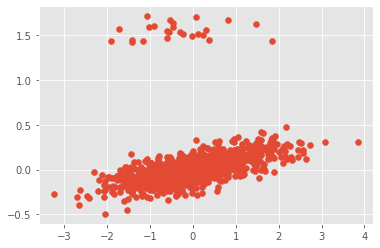

In [29]:
N = 1000
m = 25
np.random.seed(42)

X = np.random.normal(0,1, N)
x_outlier = np.random.normal(15,1, m)
noise = np.random.normal(0,0.1, N)
T = 0.1 * X + noise
T[10:10+m] = 0.1* x_outlier

X = X.reshape(N,1)
T = T.reshape(N,1)
plt.scatter(X,T)
plt.savefig('outlier.eps')

In [3]:
def log_norm(x, mu, std):
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    
    return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [4]:
class KL(torch.nn.Module):
    def __init__(self):
        super(KL, self).__init__()
        self.n_latent = 100 # Number of latent samples
        self.softplus = torch.nn.Softplus()
        
        #The parameters we adjust during training.
        self.qm = torch.nn.Parameter(torch.randn(1,1).double(), requires_grad=True)
        self.qs = torch.nn.Parameter(torch.randn(1,1).double(), requires_grad=True)
        
        #create holders for prior mean and std, and likelihood std.
        self.prior_m = torch.randn(1,1).double()
        self.prior_s = torch.randn(1,1).double()
        self.likelihood_s = torch.DoubleTensor((1))
        
        #Set the prior and likelihood moments.
        self.prior_s.data.fill_(1.0)
        self.prior_m.data.fill_(0.9)
        self.likelihood_s.data.fill_(5.5)

        
    def generate_rand(self):
        return np.random.normal(size=(self.n_latent,1))
    
    def reparam(self, eps):
        eps = Variable(torch.DoubleTensor(eps))
        return  eps.mul(self.softplus(self.qs)).add(self.qm)
    
    def compute_bound(self, x, t):
        eps = self.generate_rand()
        z = self.reparam(eps)
        q_likelihood = log_norm(z, self.qm, self.softplus(self.qs))
        prior = log_norm(z, self.prior_m, self.prior_s)
        likelihood = torch.sum(log_norm(t, x*z.transpose(0,1), self.likelihood_s), 0, keepdim=True).transpose(0,1)
        
        
        r1 = prior + likelihood -q_likelihood
        c1 = torch.max(r1)
        exp1 = torch.exp((r1-c1))
        
        KL_div = (torch.log(torch.mean(exp1)) + c1)
       
        return KL_div

In [5]:
class Renyi(torch.nn.Module):
    def __init__(self, alpha):
        super(Renyi, self).__init__()
        self.n_latent = 100 # Number of latent samples
        self.softplus = torch.nn.Softplus()
        self.alpha = alpha
        
        #The parameters we adjust during training.
        self.qm = torch.nn.Parameter(torch.randn(1,1).double(), requires_grad=True)
        self.qs = torch.nn.Parameter(torch.randn(1,1).double(), requires_grad=True)
        
        #create holders for prior mean and std, and likelihood std.
        self.prior_m = torch.randn(1,1).double()
        self.prior_s = torch.randn(1,1).double()
        self.likelihood_s = torch.DoubleTensor((1))
        
        #Set the prior and likelihood moments.
        self.prior_s.data.fill_(1.0)
        self.prior_m.data.fill_(0.9)
        self.likelihood_s.data.fill_(5.5)

        
    def generate_rand(self):
        return np.random.normal(size=(self.n_latent,1))
    
    def reparam(self, eps):
        eps = Variable(torch.DoubleTensor(eps))
        return  eps.mul(self.softplus(self.qs)).add(self.qm)
    
    def compute_bound(self, x, t):
        eps = self.generate_rand()
        z = self.reparam(eps)
        q_likelihood = log_norm(z, self.qm, self.softplus(self.qs))
        prior = log_norm(z, self.prior_m, self.prior_s)
        likelihood = torch.sum(log_norm(t, x*z.transpose(0,1), self.likelihood_s), 0, keepdim=True).transpose(0,1)
        
        r1 = (1-self.alpha)*(prior + likelihood -q_likelihood)
        c1 = torch.max(r1)
        exp1 = torch.exp((r1-c1))

        renyi_div = (torch.log(torch.mean(exp1))+c1)/(1-self.alpha)
        return renyi_div

In [6]:
class AB(torch.nn.Module):
    def __init__(self, alpha, beta):
        super(AB, self).__init__()
        self.n_latent = 100 # Number of latent samples
        self.softplus = torch.nn.Softplus()
        self.alpha = alpha
        self.beta = beta
        
        #The parameters we adjust during training.
        self.qm = torch.nn.Parameter(torch.randn(1,1).double(), requires_grad=True)
        self.qs = torch.nn.Parameter(torch.randn(1,1).double(), requires_grad=True)
        
        #create holders for prior mean and std, and likelihood std.
        self.prior_m = torch.randn(1,1).double()
        self.prior_s = torch.randn(1,1).double()
        self.likelihood_s = torch.DoubleTensor((1))
        
        #Set the prior and likelihood moments.
        self.prior_s.data.fill_(1.0)
        self.prior_m.data.fill_(0.9)
        self.likelihood_s.data.fill_(5.5)

        
    def generate_rand(self):
        return np.random.normal(size=(self.n_latent,1))
    
    def reparam(self, eps):
        eps = Variable(torch.DoubleTensor(eps))
        return  eps.mul(self.softplus(self.qs)).add(self.qm)
    
    def compute_bound(self, x, t):
        eps = self.generate_rand()
        z = self.reparam(eps)
        q_likelihood = log_norm(z, self.qm, self.softplus(self.qs))
        prior = log_norm(z, self.prior_m, self.prior_s)
        likelihood = torch.sum(log_norm(t, x*z.transpose(0,1), self.likelihood_s), 0, keepdim=True).transpose(0,1)
        
        
        r1 = (self.alpha + self.beta)*(prior + likelihood) - q_likelihood
        c1 = torch.max(r1)
        exp1 = torch.exp((r1-c1))
        
        r2 = (self.alpha + self.beta -1)* q_likelihood
        c2 = torch.max(r2)
        exp2 = torch.exp((r2-c2))
        
        r3 = self.beta * (prior + likelihood) - (1- self.alpha) * q_likelihood
        c3 = torch.max(r3)
        exp3 = torch.exp((r3-c3))

        loss1 = (torch.log(torch.mean(exp1)) + c1) / ((self.beta + self.alpha) * self.alpha ) 
        loss2 = (torch.log(torch.mean(exp2)) + c2) / ((self.beta + self.alpha) * self.beta  ) 
        loss3 = (torch.log(torch.mean(exp3)) + c3) / (self.beta * self.alpha ) 
       
        return loss1 + loss2 + loss3
    
    

In [25]:
c = KL()

optimizer = torch.optim.Adam(c.parameters(),lr=0.01)
x = torch.tensor(X)
t = torch.tensor(T)

for i in range(20001):
    loss = -c.compute_bound(x, t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 2500 ==0:
        print(c.qm.data.numpy(), (c.softplus(c.qs).data**2).numpy())

[[-1.91931296]] [[1.0857039]]
[[-0.8307887]] [[1.91108024]]
[[-0.523716]] [[1.24861403]]
[[-0.58163616]] [[0.45033719]]
[[0.27292745]] [[0.2537802]]
[[0.06132607]] [[0.07045727]]
[[-0.02649598]] [[0.02505082]]
[[0.13204943]] [[0.04144438]]
[[0.02152526]] [[0.05009009]]


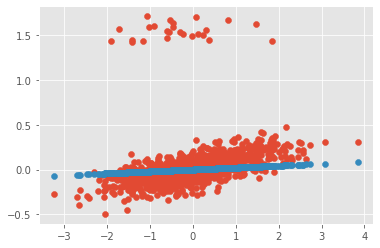

In [26]:
T1 =  c.qm.data.numpy() * X
plt.scatter(X,T)
plt.scatter(X,T1)
plt.savefig('outlier_kl.eps')

In [27]:
c = Renyi(alpha=0.2)

optimizer = torch.optim.Adam(c.parameters(),lr=0.01)
x = torch.tensor(X)
t = torch.tensor(T)

for i in range(20001):
    loss = -c.compute_bound(x, t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 2500 ==0:
        print(c.qm.data.numpy(), (c.softplus(c.qs).data**2).numpy())

[[0.24427887]] [[1.13824438]]
[[0.09777907]] [[0.02896261]]
[[0.13572139]] [[0.02946029]]
[[0.12819061]] [[0.03581896]]
[[0.1000358]] [[0.03128016]]
[[0.12311669]] [[0.02856928]]
[[0.09510443]] [[0.03168004]]
[[0.12090806]] [[0.03164128]]
[[0.15174472]] [[0.02871138]]


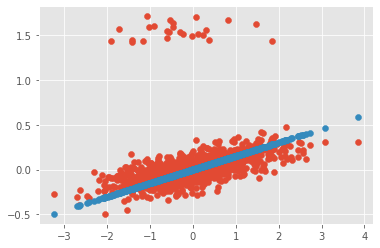

In [28]:
T1 = c.qm.data.numpy() * X
plt.scatter(X,T)
plt.scatter(X,T1)
plt.savefig('outlier_ren.eps')

In [17]:
c = AB(alpha = 2, beta = -0.25)
# alpha = 1, beta = 1
# alpha = 0.25, beta = 0.75

optimizer = torch.optim.Adam(c.parameters(),lr=0.01)
x = torch.tensor(X)
t = torch.tensor(T)

for i in range(20001):
    loss = -c.compute_bound(x, t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 2500 ==0:
        print(c.qm.data.numpy(), (c.softplus(c.qs).data**2).numpy())

[[1.6063255]] [[0.26877635]]
[[0.11022395]] [[0.15779933]]
[[0.10764497]] [[0.15941917]]
[[0.09363312]] [[0.15955148]]
[[0.1160662]] [[0.16547776]]
[[0.09108855]] [[0.1622209]]
[[0.10258131]] [[0.15328641]]
[[0.10413237]] [[0.1554254]]
[[0.10063124]] [[0.16106185]]


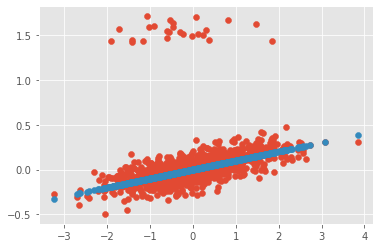

In [18]:
T1 = c.qm.data.numpy() * X
plt.scatter(X,T)
plt.scatter(X,T1)
plt.savefig('outlier_ab.eps')